# Laboratorio 4 <br> Clasificación de tweets usando minería de texto
Jeyner Arango 201106 <br>
Oscar Mendez 20302

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji, nltk
from wordcloud import WordCloud
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import re

In [47]:
nltk.download('stopwords')
english_stop_words = stopwords.words('english')
pd.set_option('display.max_colwidth', 140)
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

In [48]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [50]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [51]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [53]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


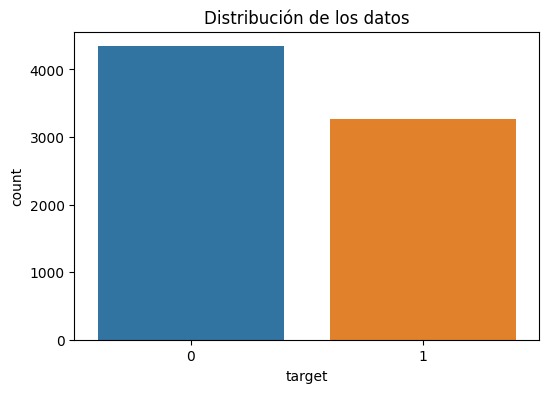

In [54]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='target')
plt.title('Distribución de los datos')
plt.show()

In [55]:
top_keywords = df['keyword'].value_counts()
top_keywords

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [56]:
df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [57]:
len(df['keyword'].unique()), df['keyword'].isna().sum(), len(df)

(222, 61, 7613)

In [58]:
top_keywords[top_keywords > 30].count()

194

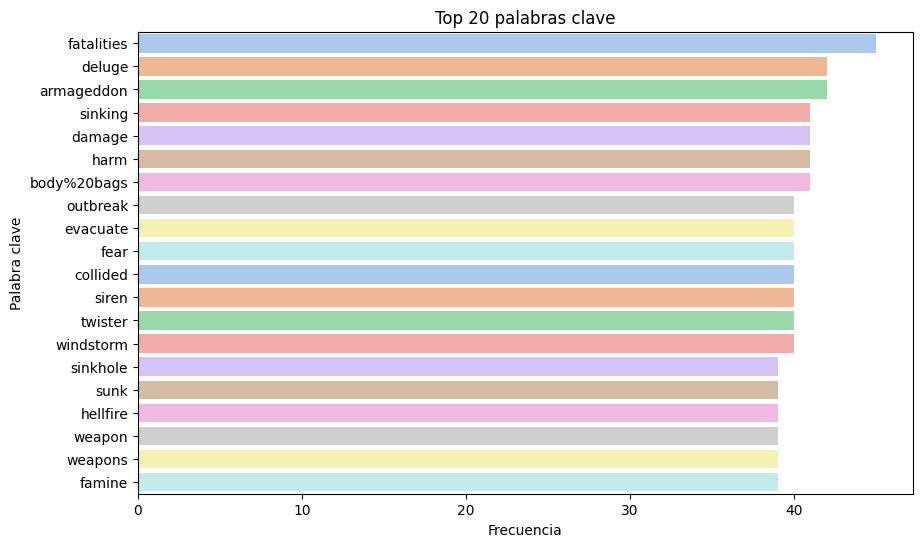

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(y=top_keywords.head(20).index, x=top_keywords.head(20).values, palette='pastel')
plt.title('Top 20 palabras clave')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra clave')
plt.show()

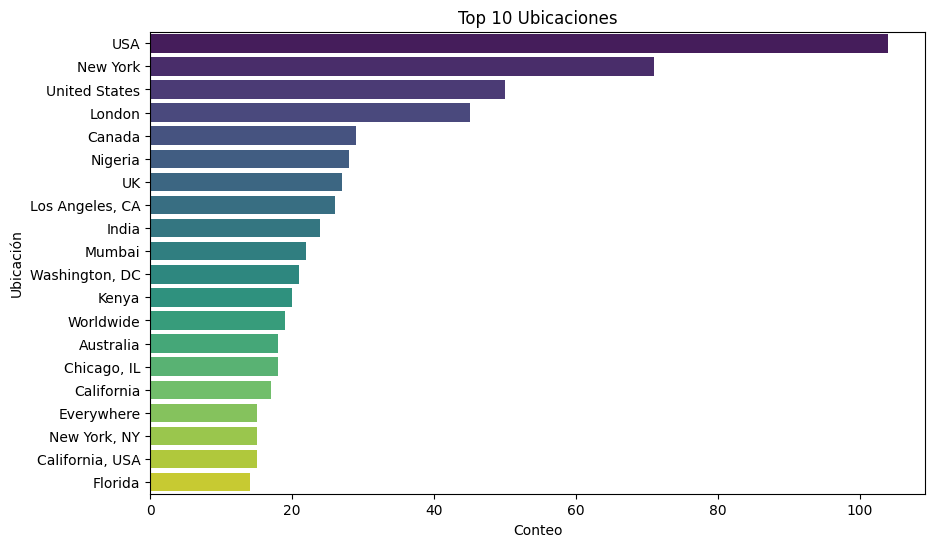

In [60]:
top_locations = df['location'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_locations.index, x=top_locations.values, palette='viridis')
plt.title('Top 10 Ubicaciones')
plt.xlabel('Conteo')
plt.ylabel('Ubicación')
plt.show()

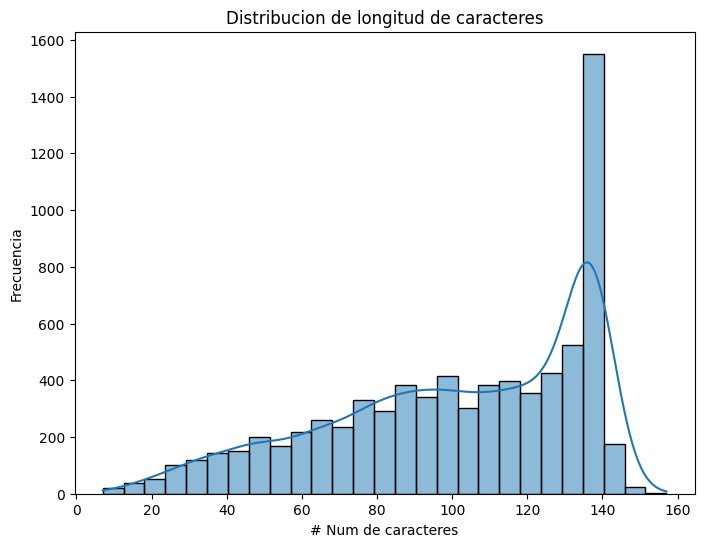

In [61]:
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='text_length', kde=True)
plt.title('Distribucion de longitud de caracteres')
plt.xlabel('# Num de caracteres')
plt.ylabel('Frecuencia')
plt.show()

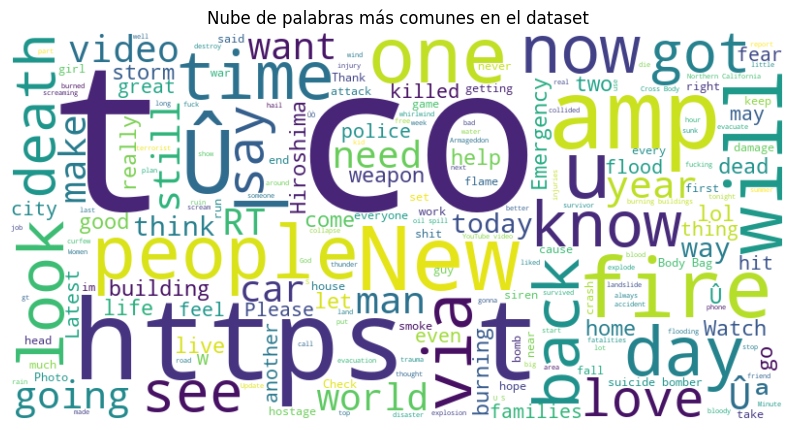

In [62]:
text_corpus = ' '.join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras más comunes en el dataset')
plt.show()

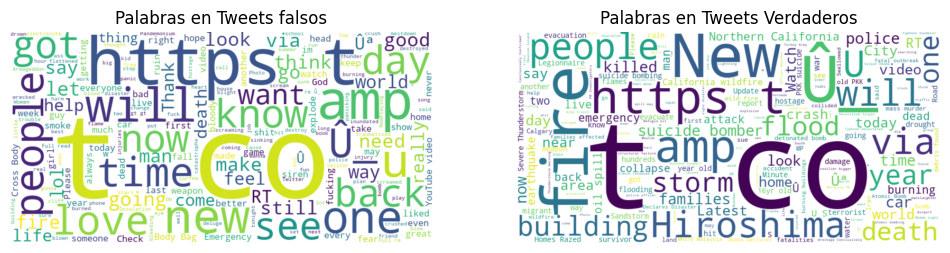

In [63]:
falso_textos = df[df['target'] == 0]['text']
real_textos = df[df['target'] == 1]['text']

# Word cloud for each target class
wordcloud0 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(falso_textos))
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(real_textos))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud0, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras en Tweets falsos')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras en Tweets Verdaderos')

plt.show()

## Limpieza

Se realizará los siguientes pasos:
- Limpieza removiendo @usernames, vínculos, números, caracteres especiales. Además pasando todo a minúscula
- Quitamos las Stop Words que son palabras comunes en un idioma que generalmente se consideran de poco valor semántico
- Realizamos Lemmatizacion que es un proceso que consiste en reducir una palabra a su forma base o canónica (de diccionario)

In [64]:
def clean_tweets(tweet):
    """ 
    removemos handles @user, links https, numeros,
    pasamos a minuscula, removemos numeros, partimos texto,
    eliminamos espacios innecesarios y volvemos a unir texto 

    @return texto limpio
    """
    tweet = tweet.replace("%20", " ").replace("&amp;", "&")
    user_removed = re.sub(r'@[A-Za-z0-9]+','',tweet)
    link_removed = re.sub('https?://[A-Za-z0-9./]+','',user_removed)
    number_removed = re.sub('[^a-zA-Z]', ' ', link_removed)
    lower_case_tweet= number_removed.lower()
    tok = WordPunctTokenizer()
    words = tok.tokenize(lower_case_tweet)
    clean_tweet = (' '.join(words)).strip()
    return clean_tweet

In [65]:
def remove_stop_words(tweet):
    removed_stop_words = ' '.join([word for word in tweet.split() if word not in english_stop_words])
    return removed_stop_words

In [66]:
def lemmatize_tweet(tweet):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tweet.split()]
    lemmatized_tweet = ' '.join(lemmatized_words)
    return lemmatized_tweet

In [67]:
df = pd.read_csv('train.csv')
df['text'] = df['text'].apply(clean_tweets).apply(lemmatize_tweet).apply(remove_stop_words)

In [68]:
df['text'].head(20)

0                                                      deed reason earthquake may allah forgive u
1                                                           forest fire near la ronge sask canada
2           resident asked shelter place notified officer evacuation shelter place order expected
3                                             people receive wildfire evacuation order california
4                                          got sent photo ruby alaska smoke wildfire pours school
5           rockyfire update california hwy closed direction due lake county fire cafire wildfire
6              flood disaster heavy rain cause flash flooding street manitou colorado spring area
7                                                                          top hill see fire wood
8                                           emergency evacuation happening building across street
9                                                                      afraid tornado coming area
10                  

Realizamos una nueva nube de palabras con los datos limpios

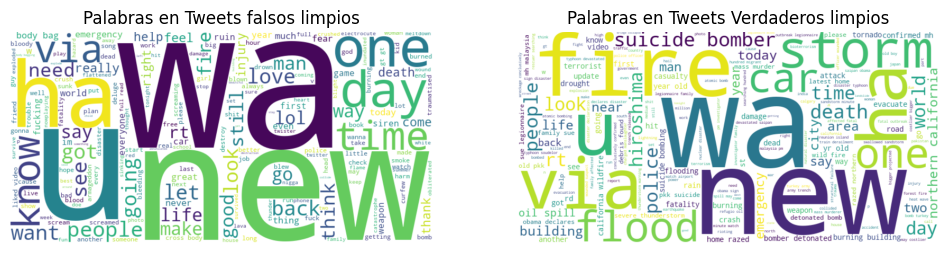

In [69]:
falso_textos = df[df['target'] == 0]['text']
real_textos = df[df['target'] == 1]['text']

# Word cloud for each target class
wordcloud0 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(falso_textos))
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(real_textos))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud0, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras en Tweets falsos limpios')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras en Tweets Verdaderos limpios')

plt.show()

## Entrenamiento

Partimos el dataset en train y validación (en lugar de test)

In [70]:
X_train, X_val, y_train, y_val = train_test_split(
    df['text'], df['target'], train_size=0.8)

### Elaboración de los diferentes modelos

#### N-Grams

In [71]:
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
ngram_vectorizer.fit(df['text'])
X_ng = ngram_vectorizer.transform(df['text'])
X_train_ng = ngram_vectorizer.transform(X_train)
X_val_ng = ngram_vectorizer.transform(X_val)

In [72]:
for c in [0.01, 0.025, 0.05, 0.10, 0.25, 0.5, 0.6, 0.75, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train_ng, y_train)
    print("Accuracy for C=%s: %s" % (c, accuracy_score(y_val, lr.predict(X_val_ng))))

Accuracy for C=0.01: 0.6979645436638214
Accuracy for C=0.025: 0.7511490479317138
Accuracy for C=0.05: 0.7774130006565988
Accuracy for C=0.1: 0.7879185817465528
Accuracy for C=0.25: 0.7931713722915299
Accuracy for C=0.5: 0.7964543663821405
Accuracy for C=0.6: 0.7957977675640184
Accuracy for C=0.75: 0.7957977675640184
Accuracy for C=1: 0.7957977675640184


In [83]:
final_ngram = LogisticRegression(C=0.5)
final_ngram.fit(X_ng, df['target'])

LogisticRegression(C=0.5)

#### Word Counts

In [74]:
wc_vectorizer = CountVectorizer(binary=False)
wc_vectorizer.fit(df['text'])
X_wc = wc_vectorizer.transform(df['text'])
X_train_wc = ngram_vectorizer.transform(X_train)
X_val_wc = ngram_vectorizer.transform(X_val)

In [75]:
for c in [0.01, 0.025, 0.05, 0.10, 0.25, 0.5, 0.6, 0.75, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train_wc, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val_wc))))

Accuracy for C=0.01: 0.6979645436638214
Accuracy for C=0.025: 0.7511490479317138
Accuracy for C=0.05: 0.7774130006565988
Accuracy for C=0.1: 0.7879185817465528
Accuracy for C=0.25: 0.7931713722915299
Accuracy for C=0.5: 0.7964543663821405
Accuracy for C=0.6: 0.7957977675640184
Accuracy for C=0.75: 0.7957977675640184
Accuracy for C=1: 0.7957977675640184


In [84]:
final_wc = LogisticRegression(C=0.5)
final_wc.fit(X_wc, df['target'])

LogisticRegression(C=0.5)

#### TF-IDF (term frequency-inverse document frequency)

In [77]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df['text'])
X_tfidf = tfidf_vectorizer.transform(df['text'])
X_train_tfidf = ngram_vectorizer.transform(X_train)
X_val_tfidf = ngram_vectorizer.transform(X_val)

In [78]:
for c in [0.01, 0.025, 0.05, 0.10, 0.25, 0.5, 0.6, 0.75, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train_tfidf, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val_tfidf))))

Accuracy for C=0.01: 0.6979645436638214
Accuracy for C=0.025: 0.7511490479317138
Accuracy for C=0.05: 0.7774130006565988
Accuracy for C=0.1: 0.7879185817465528
Accuracy for C=0.25: 0.7931713722915299
Accuracy for C=0.5: 0.7964543663821405
Accuracy for C=0.6: 0.7957977675640184
Accuracy for C=0.75: 0.7957977675640184
Accuracy for C=1: 0.7957977675640184


In [85]:
final_tfidf = LogisticRegression(C=0.5)
final_tfidf.fit(X_tfidf, df['target'])

LogisticRegression(C=0.5)

#### Support Vector Machines (SVM)

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
ngram_vectorizer.fit(df['text'])
X_svm = ngram_vectorizer.transform(df['text'])
X_train_svm = ngram_vectorizer.transform(X_train)
X_val_svm = ngram_vectorizer.transform(X_val)

In [81]:
for c in [0.01, 0.025, 0.05, 0.10, 0.25, 0.5, 0.6, 0.75, 1]:
    svm = LinearSVC(C=c)
    svm.fit(X_train_svm, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val_svm))))

Accuracy for C=0.01: 0.788575180564675
Accuracy for C=0.025: 0.7918581746552856
Accuracy for C=0.05: 0.7931713722915299
Accuracy for C=0.1: 0.7957977675640184
Accuracy for C=0.25: 0.7918581746552856
Accuracy for C=0.5: 0.7859487852921865
Accuracy for C=0.6: 0.7852921864740644
Accuracy for C=0.75: 0.7846355876559422
Accuracy for C=1: 0.7852921864740644


C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [86]:
final_svm_ngram = LinearSVC(C=0.10)
final_svm_ngram.fit(X_svm, df['target'])

LinearSVC(C=0.1)

## Función para clasificar un tweet si es Tragedia o No

In [88]:
def procesado_y_predicción(df):
    tweets = df['text']
    cleaned_texts = texts.apply(clean_tweets).apply(lemmatize_tweet).apply(remove_stop_words)
    X = ngram_vectorizer.transform(cleaned_texts)
    predictions = final_ngram.predict(X)

    # Retornar vector con 1s para Tragedias o 0s si no 
    return predictions